In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
data_path = "https://raw.githubusercontent.com/felipeangelimvieira/prophetverse/main/docs/examples/tourism.csv"

raw_data_df = pl.read_csv(data_path, try_parse_dates=True)

data_df = raw_data_df.select(pl.all().name.to_lowercase())

data_df.head()

,quarter,region,state,purpose,trips
i64,date,str,str,str,f64
1,1998-01-01,"""Adelaide""","""South Australia""","""Business""",135.07769
2,1998-04-01,"""Adelaide""","""South Australia""","""Business""",109.987316
3,1998-07-01,"""Adelaide""","""South Australia""","""Business""",166.034687
4,1998-10-01,"""Adelaide""","""South Australia""","""Business""",127.160464
5,1999-01-01,"""Adelaide""","""South Australia""","""Business""",137.448533


In [3]:
data_df.group_by("state").agg(pl.col("region").n_unique().alias("n_regions"))

state,n_regions
str,u32
"""Western Australia""",5
"""Northern Territory""",13
"""ACT""",1
"""Queensland""",12
"""New South Wales""",13
"""Victoria""",21
"""South Australia""",12


In [4]:
assert (
    data_df["region"].n_unique()
    == data_df.group_by("state")
    .agg(pl.col("region").n_unique().alias("n_regions"))["n_regions"]
    .sum()
)

In [5]:
data_df["purpose"].unique()

purpose
str
"""Holiday"""
"""Business"""
"""Other"""
"""Visiting"""


In [6]:
assert (
    data_df["purpose"].unique().shape[0]
    == data_df.group_by("region")
    .agg(pl.col("purpose").n_unique().alias("n_purposes"))["n_purposes"]
    .unique()
    .item()
)

In [7]:
data_df = data_df.with_columns(
    unique_id=pl.concat_str(
        [pl.col("state"), pl.col("region"), pl.col("purpose")], separator="::"
    )
)

data_df["unique_id"].n_unique()

308

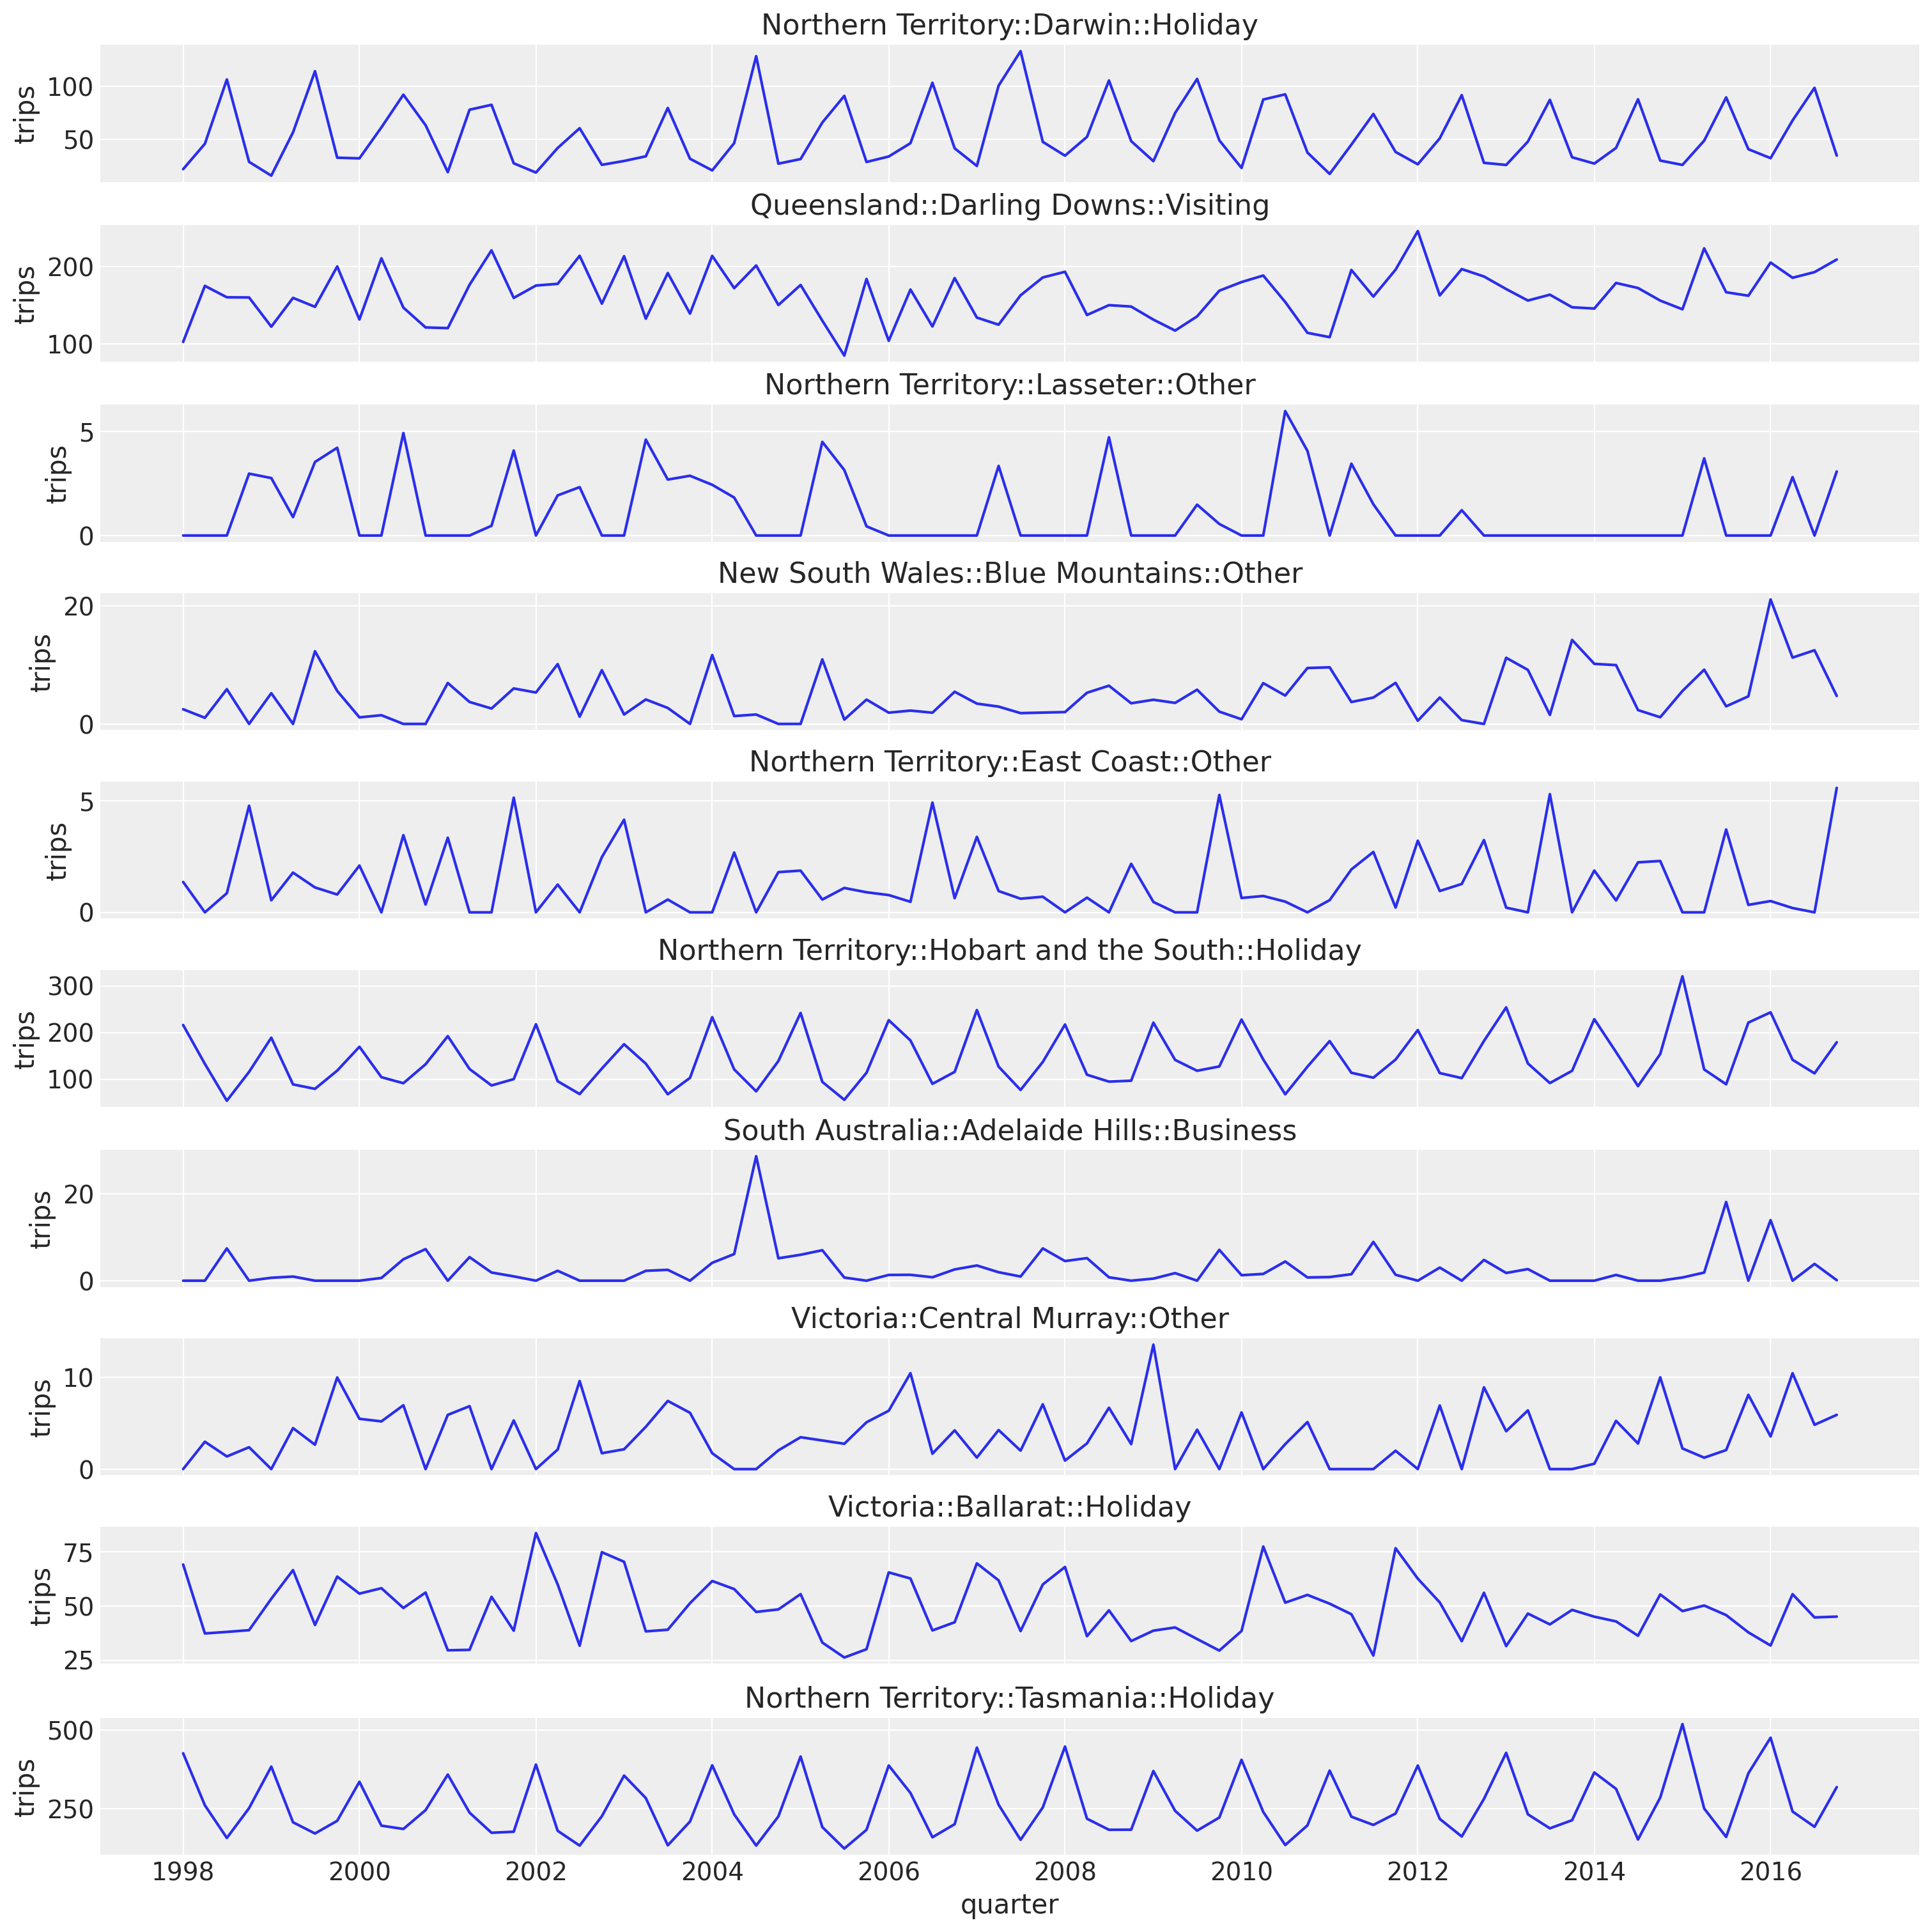

In [8]:
n_series = 10

unique_ids = data_df.select("unique_id").sample(
    n=n_series, with_replacement=False, seed=42
)

fig, axes = plt.subplots(
    nrows=n_series,
    ncols=1,
    figsize=(15, 15),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, unique_id in enumerate(unique_ids["unique_id"]):
    ax = axes[i]
    sns.lineplot(
        data=data_df.filter(pl.col("unique_id") == unique_id),
        x="quarter",
        y="trips",
        ax=ax,
    )
    ax.set(title=unique_id)

In [9]:
pivot_data_df = data_df.pivot(index="quarter", columns="unique_id", values="trips")  # noqa: PD010

In [10]:
n_test = 12

pivot_data_train_df = pivot_data_df[:-n_test, :]

pivot_data_test_df = pivot_data_df[-n_test:, :]

assert (
    pivot_data_train_df.shape[0] + pivot_data_test_df.shape[0] == pivot_data_df.shape[0]
)

In [11]:
y_train = pivot_data_train_df.drop("quarter").to_jax()
y_test = pivot_data_test_df.drop("quarter").to_jax()

In [12]:
train_unique_ids = pivot_data_train_df.drop("quarter").columns
test_unique_ids = pivot_data_test_df.drop("quarter").columns

train_dates = pivot_data_train_df["quarter"].dt.strftime("%Y-%m-%d").to_numpy()
test_dates = pivot_data_test_df["quarter"].dt.strftime("%Y-%m-%d").to_numpy()

In [13]:
def model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max, n_series = y.shape

    with numpyro.plate("series", n_series, dim=-1):
        # --- Priors ---

        ## Level
        level_smoothing = numpyro.sample(
            "level_smoothing", dist.Beta(concentration1=1, concentration0=1)
        )

        level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

        ## Noise
        noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

        # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise).to_event(0))
        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:, ...])

In [14]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [15]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, model, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
idata = az.from_numpyro(
    posterior=mcmc,
    coords={"unique_id": train_unique_ids},
    dims={
        "level_init": ["unique_id"],
        "level_smoothing": ["unique_id"],
        "noise": ["unique_id"],
    },
)

print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


In [17]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [18]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast = forecast(rng_subkey, model, mcmc.get_samples(), y_train, n_test)

In [19]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"unique_id": train_unique_ids, "date": test_dates},
        dims={"y_forecast": ["date", "unique_id"]},
    )
)

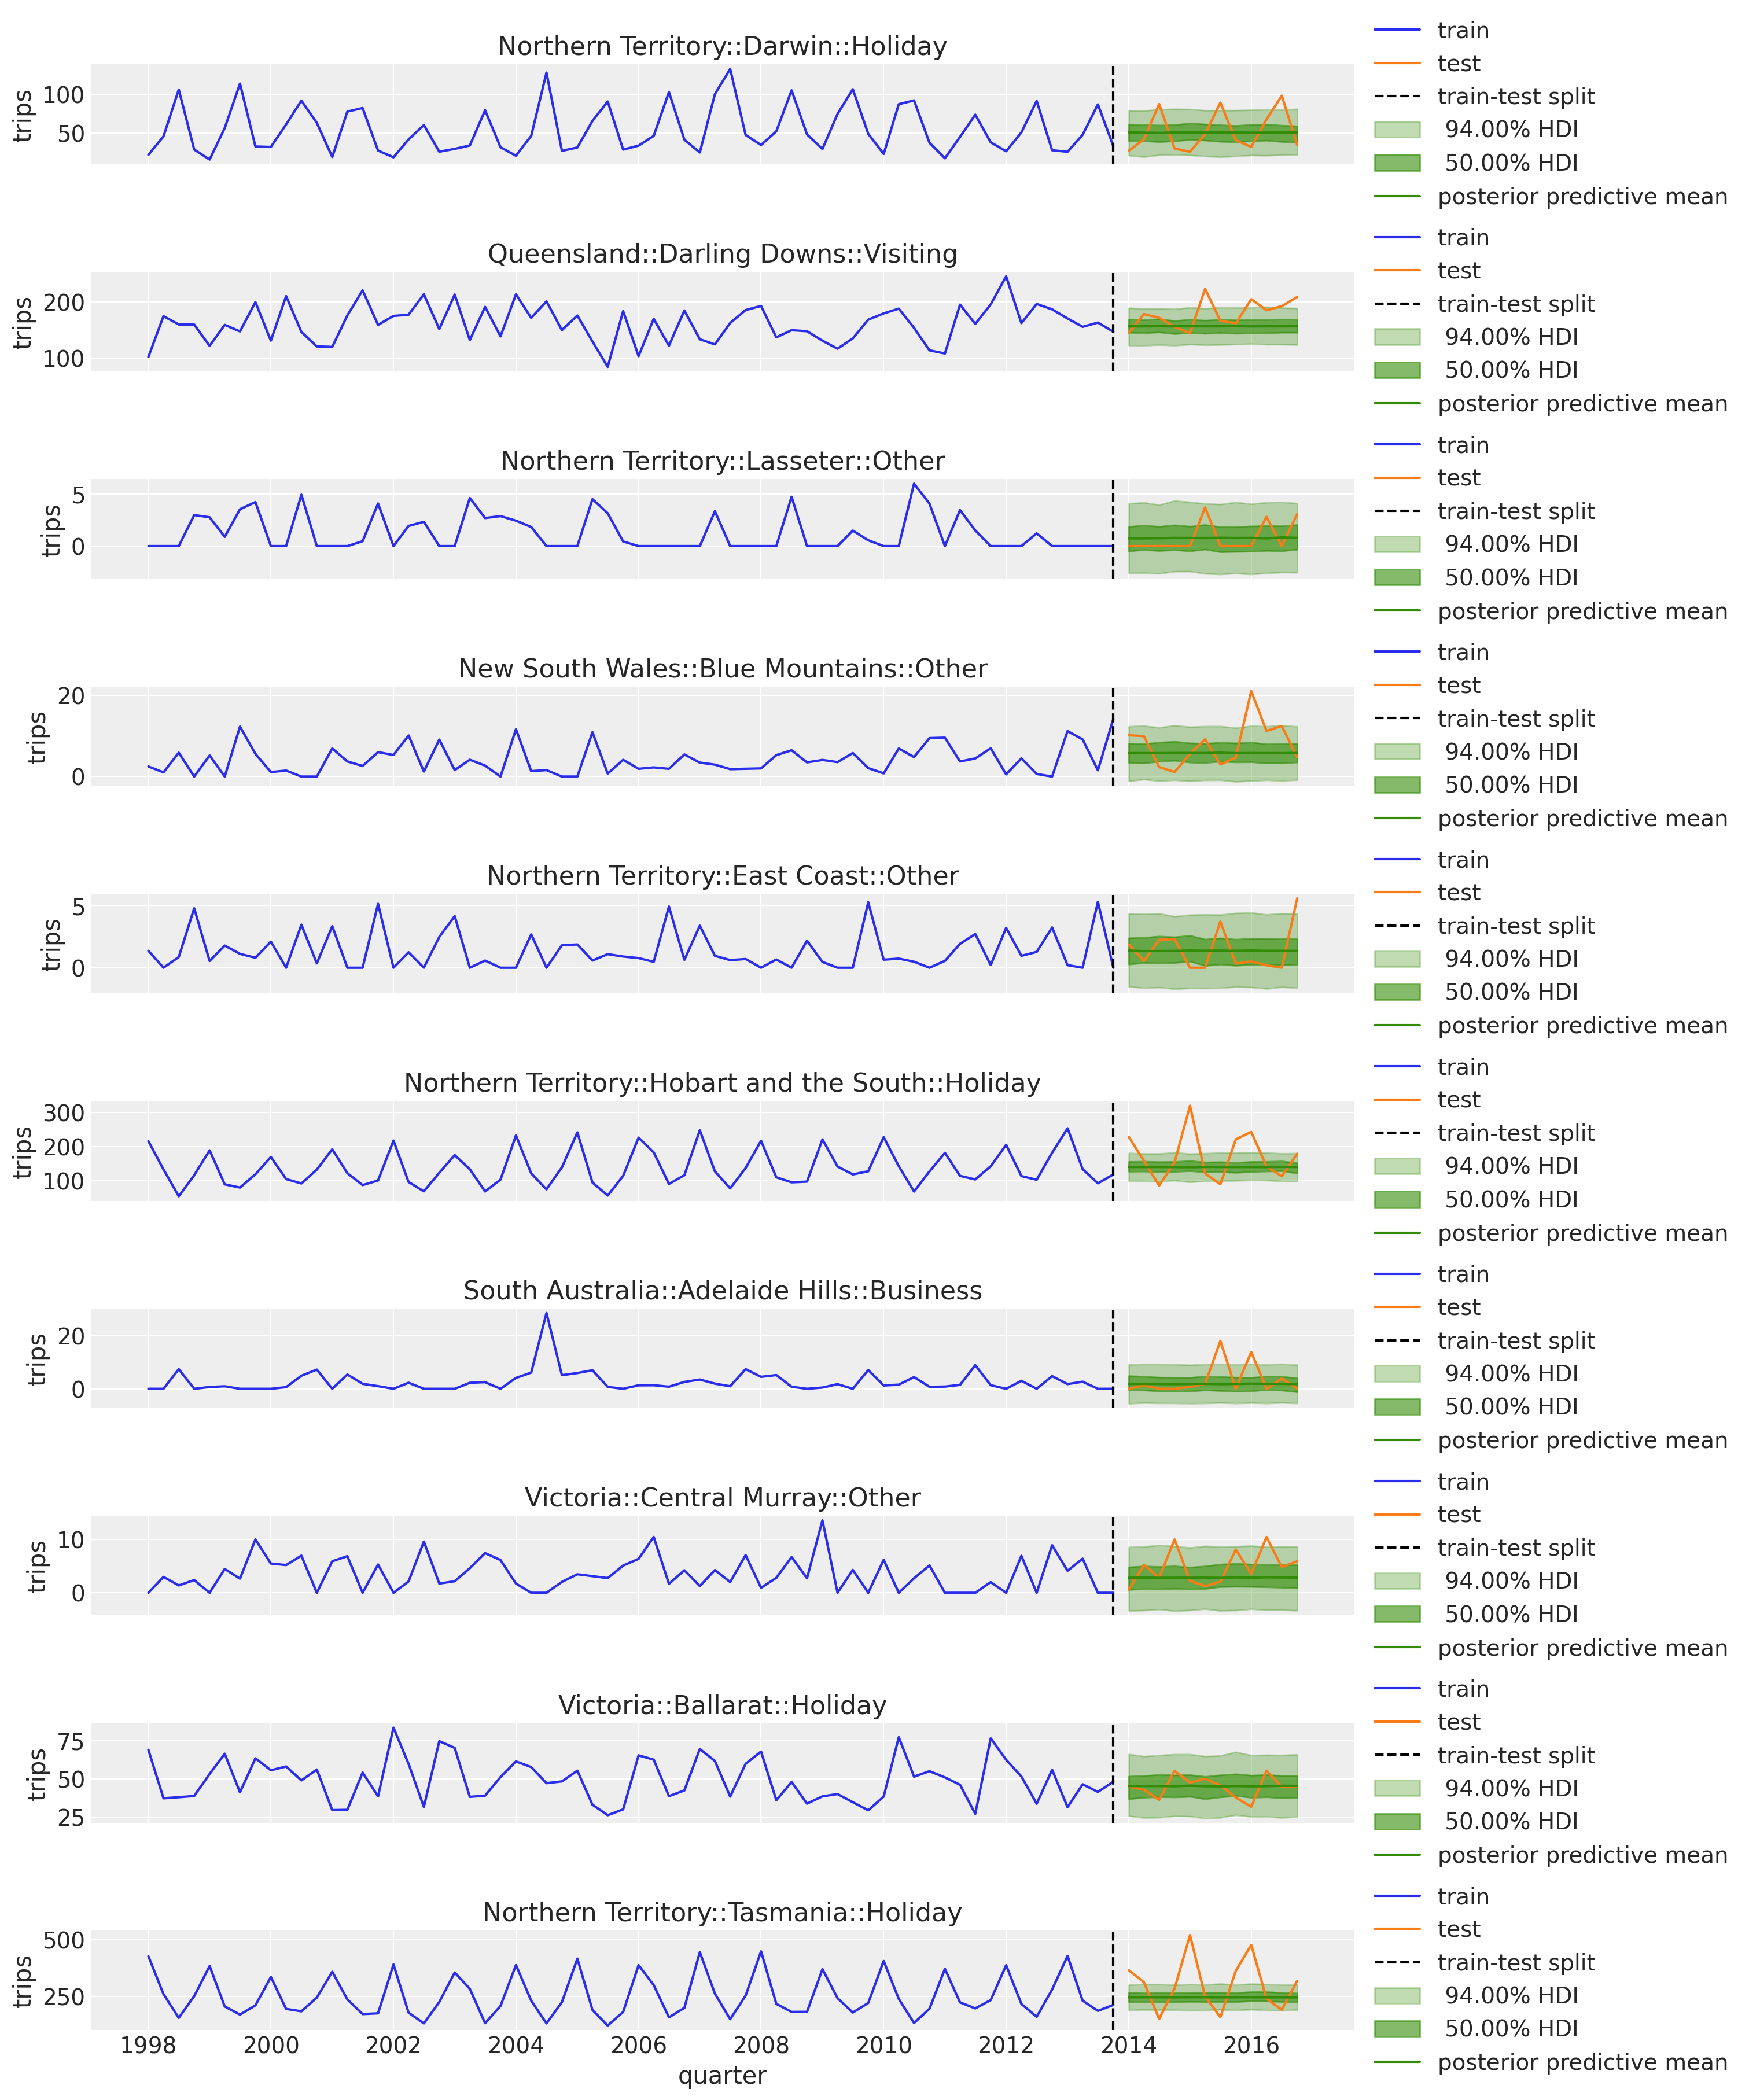

In [38]:
fig, axes = plt.subplots(
    nrows=n_series,
    ncols=1,
    figsize=(15, 18),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, unique_id in enumerate(unique_ids["unique_id"]):
    ax = axes[i]
    sns.lineplot(
        x=pivot_data_train_df["quarter"],
        y=pivot_data_train_df[unique_id],
        color="C0",
        label="train",
        ax=ax,
    )
    sns.lineplot(
        x=pivot_data_test_df["quarter"],
        y=pivot_data_test_df[unique_id],
        color="C1",
        label="test",
        ax=ax,
    )
    ax.axvline(
        pivot_data_train_df["quarter"].tail(1),
        color="black",
        linestyle="--",
        label="train-test split",
    )

    for j, hdi in enumerate([0.94, 0.5]):
        az.plot_hdi(
            x=pivot_data_test_df["quarter"],
            y=idata.posterior_predictive["y_forecast"].sel(unique_id=unique_id),
            hdi_prob=hdi,
            smooth=False,
            color="C2",
            fill_kwargs={"alpha": 0.3 * (j + 1), "label": f"{hdi: .2%} HDI"},
            ax=ax,
        )

    sns.lineplot(
        x=pivot_data_test_df["quarter"],
        y=idata.posterior_predictive["y_forecast"]
        .sel(unique_id=unique_id)
        .mean(dim=("chain", "draw")),
        color="C2",
        label="posterior predictive mean",
        ax=ax,
    )

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=unique_id, ylabel="trips")

In [29]:
unique_id

'Northern Territory::Tasmania::Holiday'